# Lab 4: Non-negative Matrix Factorization
### Students: Alassane DIALLO

The goal of this lab session is to code a NMF algorithm and use it in some applications.

You have to send the filled notebook named **"NMF_familyname1_familyname2.ipynb"** (groups of 2) by email to *aml.centralesupelec.2020@gmail.com* a week from now and put **"NMF Lab"** in the subject. 

All questions will be graded unless it is explicitely indicated.

We begin with the standard imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.linalg import norm
from scipy import linalg
from numpy import multiply
from sklearn.decomposition import NMF
import time 

%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

## NMF

Loss (Regularized Froebnius): $\mathcal{L}(D, S) = \frac{1}{2}\|X-D S\|_{F}^{2}+ \color{red}{\frac{\mu}{2}\|S\|_{F}^{2}+\lambda\|S\|_{1}+\frac{\nu}{2}\|D\|_{F}^{2}}$

Algorithm (multiplicative updates from [Lee and Seung, 1999]: 

\begin{array}{c}
D \leftarrow D \circ \frac{X S^{\top}}{D (S S^{\top} + {\color{red} \nu I_r})} \\
S \leftarrow S \circ \frac{D^{\top} X - {\color{red} \lambda 1_{r \times n}}}{(D^{\top} D + {\color{red} \mu I_r})S}
\end{array}

Fill in the following NMF class:

In [2]:
class MYNMF():
    
    def __init__(self, n_components, mu=1e-4, nu=1e-4, lambd=1e-4, epsilon=1e-5, random_state=7, max_iter=200, init_method="random"):
        self.n_components_ = n_components
        self.max_iter_ = max_iter
        self.loss_ =list()
        self.epsilon_ = epsilon
        self.D_ = None
        self.S_ = None
        self.mu_ = mu
        self.nu_ = nu
        self.lambd_ = lambd
        self.random_state_ = random_state
        assert init_method in ["random", "svd", "svd_abs", "svd_pos", "svd_neg"], "method not implemented"
        self.init_method_ = init_method
        self.ratio_negative_D_ = []
        self.ratio_negative_S_ = []
       
    def fit_transform(self, X, mu=1., lambd=1., nu=1.):
        """ Find the parameters mu_ and Sigma_
        that better fit the data
        
        Parameters:
        -----------
        X: (n, p) np.array
               Data matrix
        
        Returns:
        -----
        embedding: (n, r) np.array
                    Embedding matrix        
        """        

        n, p = X.shape
        r = self.n_components_
        if self.random_state_ is not None: np.random.seed(self.random_state_)
        if self.init_method_=="random":
          self.D_ = np.random.rand(n, self.n_components_)
          self.S_ = np.random.rand(self.n_components_, p)
        elif self.init_method_[:3] == "svd":
          U, s, Vh = linalg.svd(X)
          S_red = np.diag(np.sqrt(s)[:self.n_components_])
          self.D_ = U[:, :self.n_components_] @ S_red
          self.S_ = S_red @ Vh[:self.n_components_, :]

          if self.init_method_=="svd_abs":
            self.D_ = np.abs(self.D_)
            self.S_ = np.abs(self.S_)
          
          if self.init_method_=="svd_pos":
            self.D_[self.D_<0] = 0
            self.S_[self.S_<0] = 0
            
          if self.init_method_=="svd_neg":
            self.D_[self.D_>0] = 0
            self.S_[self.S_>0] = 0

            self.D_ = -self.D_
            self.S_ = -self.S_
          

        LOSS = 0.5 * norm(X - np.dot(self.D_, self.S_)) ** 2 + \
            self.mu_ * norm(self.S_) ** 2 + self.lambd_ * norm(self.S_, 1) + \
            (self.nu_ / 2) * norm(self.D_) ** 2
        rLOSS = LOSS / (norm(X) ** 2)
        self.loss_.append(LOSS)
        it = 0
        while (rLOSS > self.epsilon_ and it < self.max_iter_):
          D_up = X @ self.S_.T
          D_down = self.D_ @ (self.S_ @ self.S_.T + self.nu_ * np.eye(r))
          A = D_up / D_down
          self.D_ = multiply(self.D_, A)

          S_up = self.D_.T @ X - self.lambd_ * np.hstack((np.eye(r), np.zeros((r, p - r))))
          S_down = (self.D_.T @ self.D_ + self.mu_ * np.eye(r)) @ self.S_
          B = S_up / S_down
          self.S_ = multiply(self.S_, B)

          # Counts the number of negative elements to check constraints
          self.ratio_negative_D_.append(np.round(len(np.where(self.D_<0)[0]) / self.D_.size, 2)) 
          self.ratio_negative_S_.append(np.round(len(np.where(self.S_<0)[0]) / self.S_.size, 2))
 
          # Computes loss at each iteration
          LOSS = 0.5 * norm(X - np.dot(self.D_, self.S_)) ** 2 + \
              self.mu_ * norm(self.S_) ** 2 + self.lambd_ * norm(self.S_, 1) + \
              (self.nu_ / 2) * norm(self.D_) ** 2
          
          rLOSS = LOSS / (norm(X) ** 2)
          self.loss_.append(LOSS)

          it += 1

        return self.D_
    
    
    def inverse_transform(self):
        """ Maps an embedding matrix into the original space. 
        
        Parameters:
        -----------
        embedding : (n, r) np.array
                     Embedding matrix
        
        Returns:
        -----
        data_hat : (n, p) np.array  
                   reconstructed data matrix
        """       
        data_hat = self.D_ @ self.S_

        return data_hat

    def predict_label(self):
        """ Predict labels for X : cluster hard-assignment
        
        Parameters:
        -----------
        X: (n, p) np.array
           data matrix
        
        Returns:
        -----
        label assignment : (n, ) np.array
                          Its elements are the predicted classes, from 0 to r-1
        """
        # embedding = fit_transform(X)
        labels = np.argmax(self.S_, axis=0)       
        return labels
        
    def predict_proba(self):
        """ Predict probabilities of different classes for X :  cluster soft-assignment
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        label assignment : (n, r) np.array
                          Its elements are the probabilities for different classes
        """
        # embedding = fit_transform(X)
        proba = (self.S_ / np.sum(self.S_, axis=0)).T
        
        return proba

    def check_constraints(self):
        nb_negatives_D = len(np.where(self.D_<0)[0])
        nb_negatives_S = len(np.where(self.S_<0)[0])
        if (nb_negatives_D==0 & nb_negatives_S==0):
          print("Constraints are respected.")
        else:
          print("Warning: Constraints are not respected!")
          print(f"Ratio of negative elements in W: {np.round(nb_negatives_D / self.D_.size, 2)}")
          print(f"Ratio of negative elements in H: {np.round(nb_negatives_S / self.S_.size, 2)}")


    def plot_loss(self,X):
        
        plt.figure(figsize=(10,8))
        plt.plot(self.loss_,label=f"nb_components={self.nb_components_}")
        plt.xlabel("number of iteration")
        plt.ylabel("loss function")
        plt.legend()
        plt.show()

## Applications

### First application

For the first application you are going to analyse the following data to give an interpretation of the factorization:

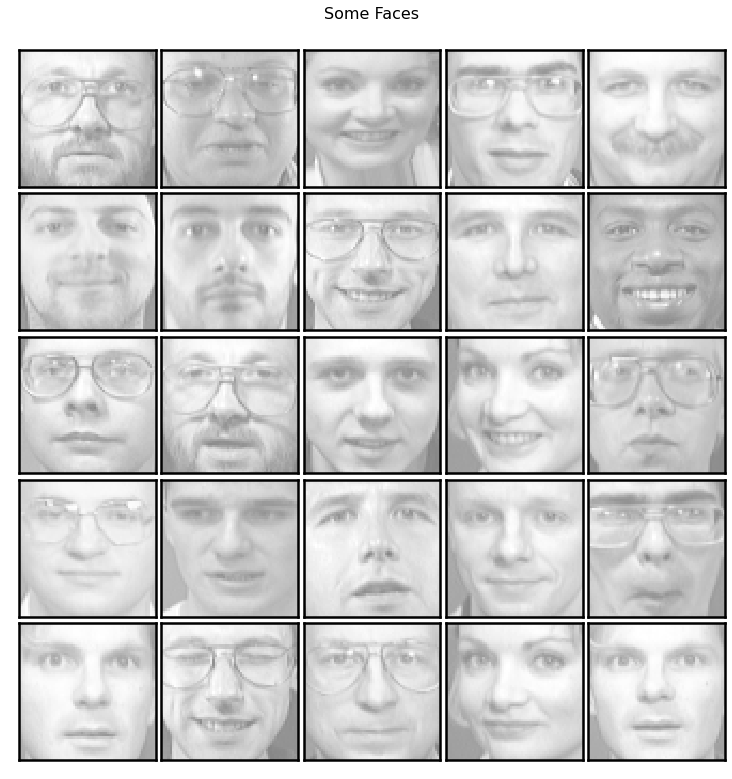

In [3]:
from sklearn.datasets import fetch_olivetti_faces


dataset = fetch_olivetti_faces(shuffle=True)

faces = dataset.data  # n = 400 flattened images of p = 4096 = 64 x 64
image_shape = (64, 64)

n_samples, n_features = faces.shape

# global centering
faces_centered = faces - faces.mean(axis=0)

# local centering
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

def plot_gallery(images, image_shape, title='', cmap=plt.cm.gray):
    
    # fit the nb of images into a square
    n_images = len(images)
    nrows = int(np.ceil(np.sqrt(n_images)))
    ncols = nrows
    
    # instantiate figure
    fig, axes = plt.subplots(nrows, ncols, figsize=(2. * ncols, 2.26 * nrows))
    fig.suptitle(title, size=16)
    
    axes_for_display = axes.flatten()[:n_images]
    axes_to_blank = axes.flatten()[n_images:]
    
    for idx, comp in enumerate(images):
        ax = axes_for_display[idx]
        vmax = max(comp.max(), -comp.min())
        ax.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        ax.set(xticks=(),
               yticks=())
        
    for ax in axes_to_blank:
        ax.axis('off')

    fig.tight_layout()
    fig.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)  # insert space below the suptitle
    

plot_gallery(title="Some Faces", 
             images=faces[:25], 
             image_shape=image_shape)


Apply *your* NMF algorithm for this dataset and plot the approximated face pictures.

- Plot the $W$ matrix as images in a $(\sqrt{r}, \sqrt{r})$ grid
- Explain how to interpret both matrices W and H.
- Discuss the results you have obtained
- Conduct a critical analysis of your choice. Concretely, choose an aspect or two of the NMF method (e.g. Loss, Clustering, Geometry of the Embedding Space, Choice of the number of components r, any other of your choice), write code for it, test it, present (a) figure(s), and discuss. 

### 1. Applying NMF on the images dataset
We transpose the faces array so that we have the samples (images) on the columns and the features (pixels) in the lines. This will help us understand better NMF as a clustering procedure.

Constraints are respected.


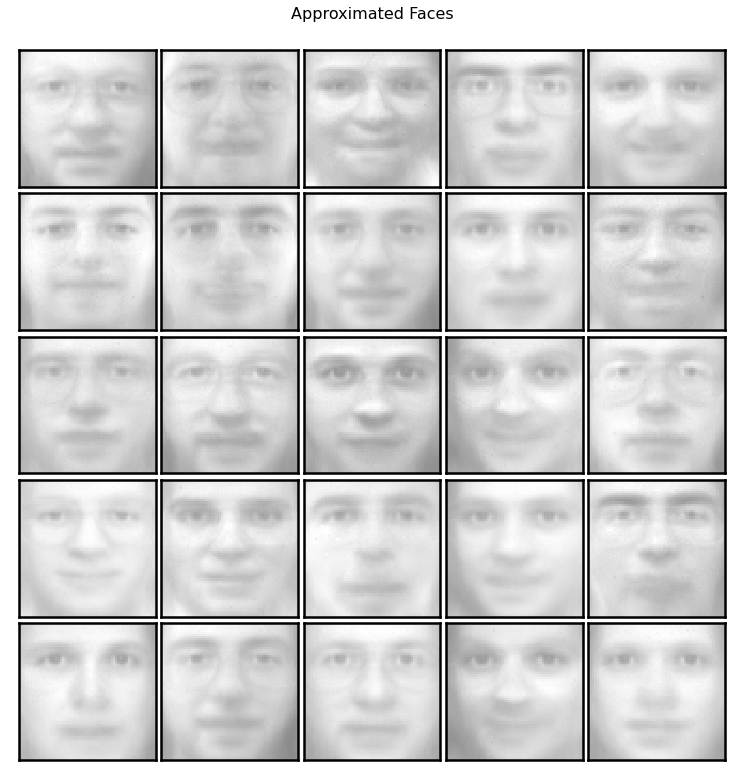

In [4]:
  model = MYNMF(n_components = 16, lambd = 1e-4, mu = 1e-4, nu = 1e-4, epsilon = 1e-5, max_iter = 200, random_state=7)
  embedding = model.fit_transform(faces.T)
  model.check_constraints()
  faces_nmf = (model.D_ @ model.S_).T
  plot_gallery(title="Approximated Faces", 
             images=faces_nmf[:25], 
             image_shape=(64, 64))

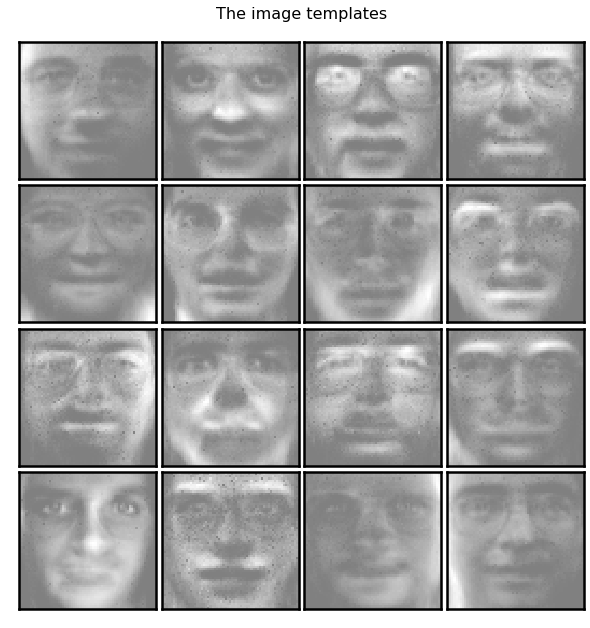

In [5]:
plot_gallery(title="The image templates", 
             images=model.D_.T, 
             image_shape=(64, 64))

### 2. Interpretation of the NMF decomposition
We remind here that X is the matrix where each column is an image described by the pixels intensity. 
- Interpretation of W: The matrix W contains the image templates that can be used to reconstruct approximatively with the right factors the image dateset.
Each column is the image template described in the space of the features (pixels).
- Interpretation of H: The matrix H tells how each template contributes to the description of the images. $H_{j,k}$ represents how the $k^{th}$ image is represented by the $j^{th}$ image template.

<br>This decomposition can also be interpreted as a clustering procedure, where we look to find an inherent structure to the data contained in the dataset, by trying to put the images in different clusters which centroids describe the images in the best possible way. This means that the $k^{th}$ image is contained in the cluster $j$ (of centroid the image template $W_{.,j}$) with a weight of $H_{j,k}$. This weight tells how much the image $k$ is described by the template $j$.
<br> We can consider this procedure as a fuzzy clustering, and (after normalizing H) each coefficent $H_{j,k}$ as the probability of the $k^{th}$ pixel being in the $j^{th}$ feature cluster. A deterministic clustering can be deduced by taking the cluster with the maximum probabity between the $H_{j,k}$ for each pixel $k$. But it's better to keep the notion of fuzzy clustering because each image is described by more than one template.

### 3. Discussion of the results
When we look at the 16 image templates extracted by NMF, we see that some face features are highlighted like eyebrows, noise, face shape, eyes glasses...

Judging by the first 25 instances, the approximated faces images show these features in the original images are overall kept after the NMF decomposition, while other features (like skin color, gender, eyes orientation) cannot be recognized after this procedure.




Let's take for example a picture well reproduced by the NMF (for example the 2nd image) and another one that was not well represented after the decomposition (for example the 17th image) to see how they are described by the image templates. We consider in each case only the best 5 templates.

In [6]:
proba = np.sort(model.predict_proba()[1, :])[::-1] [:5]
templ_clusters = np.argsort(model.predict_proba()[1 ,:])[::-1] [:5]
for i, templ in enumerate(templ_clusters):
    print(f"template = {templ}, proba = {np.round(proba[i], 3)}")

template = 15, proba = 0.174
template = 14, proba = 0.145
template = 6, proba = 0.138
template = 0, proba = 0.116
template = 7, proba = 0.098


The probabilities show a dominance towards certain templates, which means that the approximated face image is really close to these templates. Such closeness can be made possible by the fact that many images in the dataset exhibit the same face features which are highlighted in these image templates. In terms of clustering, this corresponds to a high density of data samples around a certain space region which allows to create a centroid (by kmeans for example) close to these data samples.

Now let's see the second example: 

In [7]:
proba = np.sort(model.predict_proba()[16, :])[::-1] [:5]
templ_clusters = np.argsort(model.predict_proba()[16 ,:])[::-1] [:5]
for i, templ in enumerate(templ_clusters):
    print(f"template = {templ}, proba = {np.round(proba[i], 3)}")

template = 5, proba = 0.14
template = 4, proba = 0.132
template = 15, proba = 0.106
template = 14, proba = 0.081
template = 2, proba = 0.08


For this image (17th picture of the image dataset), no templates represent well the original image in terms of face orientation, face shape, eyes or mouth shape. We can see that the factors are quite similar to each other. In the context of fuzzy clustering, this can be interpreted as an outlier because it does not have a dominant factor so a cluster where it belongs with a high probability. This indicates that this dataset does not contain enough samples to be used to extract face features describing well this image.

From the above observations, we can make the following conclusions:
- Each approximate face image is a combination of the extracted face templates.
- The face features kept by the decomposition are those that are described better in the image templates.
- The features, that are well represented by the image templates, are those that are most common among the images in this group of persons.

### 4. Critical analysis
#### 4.1. Regularization and number of components

We chose previously the number of components equal to 16, but we can search for a better parameter by minimizing the loss function.

In [26]:
loss = list()
lambd = 1e-3
mu = 1e-3
nu = 1e-3
n_components_list = [1, 2, 3, 4, 5, 6, 8, 10, 15, 20, 25, 30, 35, 40, 45, 50]
for n_components in n_components_list:
  model = MYNMF(n_components = n_components, lambd = lambd, mu = mu, nu = nu, epsilon = 1e-5, max_iter = 200)
  emb = model.fit_transform(faces.T)
  LOSS = 0.5 * norm(faces.T - np.dot(model.D_, model.S_) ** 2) + \
      model.mu_ * norm(model.S_) ** 2 + model.lambd_ * norm(model.S_, 1) + \
      model.nu_ / 2 * norm(model.D_) ** 2
  loss.append(LOSS)

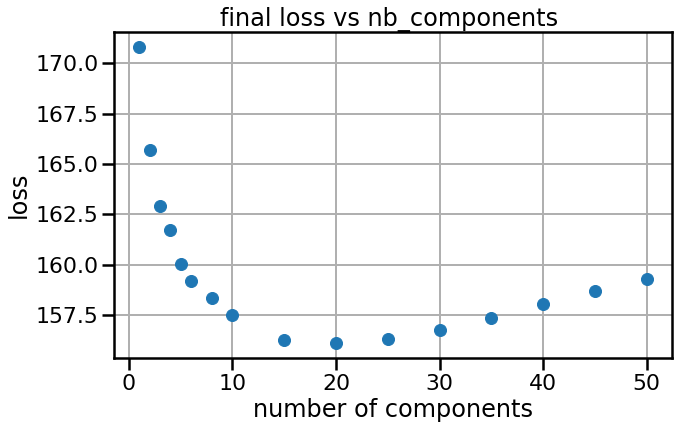

In [28]:
plt.figure(figsize = (10, 6))
plt.plot(n_components_list, loss, 'o')
plt.grid()
plt.ylabel("loss")
plt.xlabel("number of components")
plt.title("final loss vs nb_components ")
plt.show()

The goal of the NMF is to approximate the matrix X with two matrix D and S. If we apply no regularization on these matrixes (D, S), the NMF will overfit and choose the obvious values of $(D,S)=(X,I_{p})$. We can observe this by not penalize the loss function(that is $\lambda=0,\nu=0,\mu=0 $) and observing the continuous decrease of the loss function with the value of the number of component. The new regulated loss function allows us to get the optimal value for the number of components.

#### 4.2 Initialization (Random or SVD)

In [10]:
random_states = [7, 10, 17, 20, 27, 30]
loss = []
for random_state in random_states:
    model = MYNMF(n_components=16, lambd=1e-4, mu=1e-4, nu=1e-4, epsilon=1e-5, max_iter=300, random_state=random_state)
    emb = model.fit_transform(faces.T)
    loss.append(model.loss_)

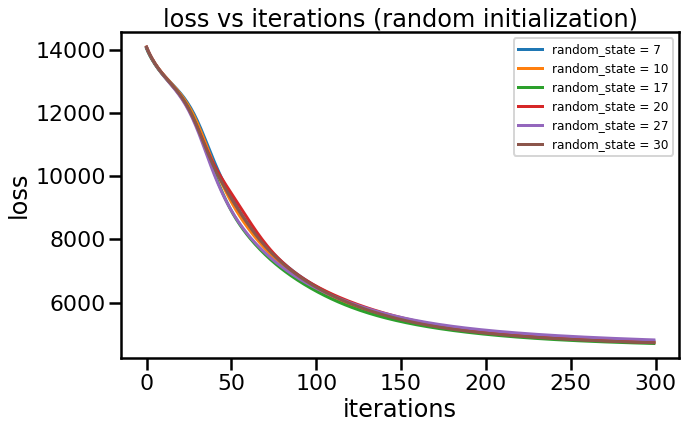

In [11]:
plt.figure(figsize = (10, 6))
for i in range(len(random_states)):
  plt.plot(loss[i][1:], label=f"random_state = {random_states[i]}")
  plt.ylabel("loss")
  plt.xlabel("iterations")
  plt.title("loss vs iterations (random initialization)")
  plt.legend(prop={'size': 12})
plt.show()

We plot the loss vs iterations starting from the second iteration because the first one corresponds to a high loss. No much variance is observed for different random seeds, especially near the minimum. This proves that the algorithm convergence is robust to different initializations.

In [12]:
model_svd = MYNMF(n_components=16, lambd=1e-4, mu=1e-4, nu=1e-4, epsilon=1e-5, max_iter=200, init_method = "svd", random_state=7)
st = time.time()
emb = model_svd.fit_transform(faces.T)
ed = time.time()
loss_svd = model_svd.loss_
exec_time_svd = ed - st

model_random = MYNMF(n_components=16, lambd=1e-4, mu=1e-4, nu=1e-4, epsilon=1e-5, max_iter=200, init_method = "random", random_state=7)
st = time.time()
emb = model_random.fit_transform(faces.T)
ed = time.time()
loss_random = model_random.loss_
exec_time_random = ed - st

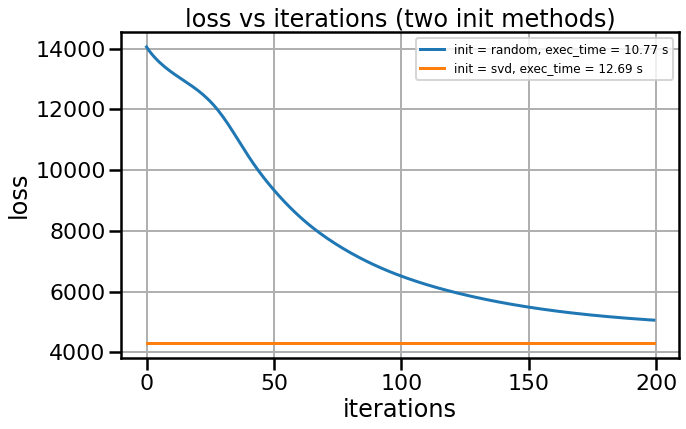

In [13]:
plt.figure(figsize = (10, 6))
plt.plot(loss_random[1:], label=f"init = random, exec_time = {np.round(exec_time_random, 3)} s")
plt.plot(loss_svd[1:], label=f"init = svd, exec_time = {np.round(exec_time_svd, 3)} s")
plt.ylabel("loss")
plt.xlabel("iterations")
# plt.ylim(bottom=0, top = np.max(loss[i][1:]) *2 )
plt.title("loss vs iterations (two init methods)")
plt.legend(prop={'size': 12})
plt.grid()
plt.show()

Svd initialization gives better results on this dataset on two aspects:
- We reach a better minimum for the loss function
- It's much faster on this dataset because it gives a minimum directly. What would interesting to do is to test this initialization on a larger dataset. In this case, we think that the initialization will take more time because the algorithms of this decomposition generally rely on $QR$ decomposition which is of complexity $n^3$ where $n$ is the number of samples (There are also more efficient methods which give better complexity).

<br> BUT, it does not allow to respect the constraints. As we see below, the ratio of negative elements in the two matrices is high (more than 50 %).

In [14]:
model_svd.check_constraints()

Ratio of negative elements in W: 0.53
Ratio of negative elements in H: 0.55


We can try to see if this ratio is decreasing with the number of iterations

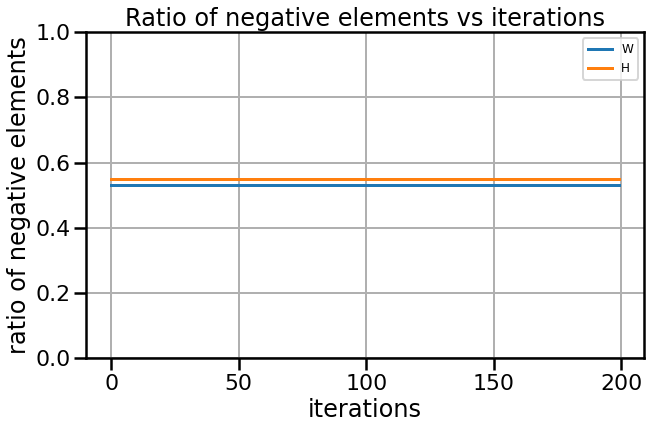

In [15]:
plt.figure(figsize = (10, 6))
plt.plot(model_svd.ratio_negative_D_, label="W")
plt.plot(model_svd.ratio_negative_S_, label="H")
plt.ylabel("ratio of negative elements")
plt.xlabel("iterations")
plt.ylim(bottom=0, top = 1)
plt.title("Ratio of negative elements vs iterations")
plt.legend(prop={'size': 12})
plt.grid()
plt.show()

Normal SVD cannot be used directly to initialize the matrices for the NMF. We should try to transform the result of SVD into non negative matrices in order to respect the non-negative constraint.
<br> A simple and intuitive idea is to apply absolute value function in an element-wise manner to the initialization matrices of the SVD. We call this method "svd_abs".

In [16]:
model_random = MYNMF(n_components=16, lambd=1e-4, mu=1e-4, nu=1e-4, epsilon=1e-5, max_iter=200, init_method = "random", random_state=7)
st = time.time()
emb = model_random.fit_transform(faces.T)
ed = time.time()
loss_random = model_random.loss_
exec_time_random = ed - st

model_svd_abs = MYNMF(n_components=16, lambd=1e-4, mu=1e-4, nu=1e-4, epsilon=1e-5, max_iter=200, init_method = "svd_abs", random_state=7)
st = time.time()
emb = model_svd_abs.fit_transform(faces.T)
ed = time.time()
loss_svd_abs = model_svd_abs.loss_
exec_time_svd_abs = ed - st

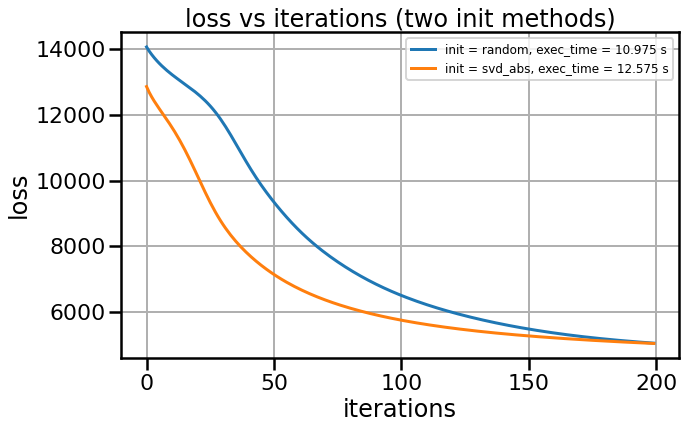

In [17]:
plt.figure(figsize = (10, 6))
plt.plot(loss_random[1:], label=f"init = random, exec_time = {np.round(exec_time_random, 3)} s")
plt.plot(loss_svd_abs[1:], label=f"init = svd_abs, exec_time = {np.round(exec_time_svd_abs, 3)} s")
plt.ylabel("loss")
plt.xlabel("iterations")
# plt.ylim(bottom=0, top = np.max(loss[i][1:]) *2 )
plt.title("loss vs iterations (two init methods)")
plt.legend(prop={'size': 12})
plt.grid()
plt.show()

In [18]:
model_svd_abs.check_constraints()

Constraints are respected.


We obtain a faster convergence, but most importantly, we respect the non negative constraints. The minimal reached after 200 iterations is the same, so there's no improvement on the approximation. With the method described here, we obtain an initial decomposition which gives a fairly closer approximation to the original matrix than a random approximation, which explains the faster convergence.
<br> It would interesting to try other transformations to svd initialization matrices like keeping only the positive values or the negative ones (in absolute value).

### Second application

Import the 20newsgroups dataset (from sklearn.datasets import fetch_20newsgroups_vectorized) that contains a collection of ~18,000 newsgroup documents from 20 different newsgroups.

Model the topics present in a subsample with *scikit-learn's* NMF. Print the most common words of each topic. 

Discuss.

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import NMF

n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20


def print_top_words(D, feature_names, n_top_words):
    p, r = D.shape
    for topic_idx in range(r):
        topic = D[:, topic_idx]
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()


dataset = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'))
data_samples = dataset.data[:n_samples]


# Use tf-idf features for NMF.
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(data_samples)

# Fit the NMF model, print top words
nmf = NMF(n_components=n_components)
W = nmf.fit_transform(tfidf)
print_top_words(nmf.components_.T, tfidf_vectorizer.get_feature_names(), n_top_words)


Topic #0: just people don think like know say did make really time way ve right sure good going want got wrong
Topic #1: windows use using window dos program application os drivers software help screen running ms code motif pc work ve mode
Topic #2: god jesus bible faith does christian christians christ believe life heaven sin lord church religion true mary human belief love
Topic #3: thanks know does mail advance hi info interested anybody email like looking help appreciated card information list send need post
Topic #4: car new 00 bike 10 price space cars power sale good year engine years used cost miles condition great 000
Topic #5: edu soon com send university internet ftp mail mit information article cc pub address hope program email mac blood contact
Topic #6: file problem files format ftp win space sound read pub available program site help version image book copy save memory
Topic #7: game team year games win play season players nhl runs toronto ll flyers division goal hockey p

In [20]:
new_data_sample = dataset.data[2036]  # unseen
print(new_data_sample)


Didn't Paul write that if the Resurrection is not true, we are the
biggest fools of all?  However, whether you believe in Christ or not,
His teachings (e.g. love your brotherman as yourself), even if only 
followed at a secular level, could do a great deal to alleviate some of 
the problems we see today in the world.  Even when I was a rabid atheist 
I couldn't deny that.


With which topics does the nmf model best associate this new sample? Does it make sense? What about another new sample?
<br><br> This sample is associated with Topic #2 and it does make sense to associate it with this topic.

In [21]:
new_data_sample = dataset.data[1000]  # unseen
print(new_data_sample)


Glad to hear that it's working for you!

I couldn't find it on "export".  However, Simon Leinen
<simon@liasun6.epfl.ch> has added an Imakefile and an Athena
version, and made it available for FTP in the file
liasun3.epfl.ch:/pub/X/contrib/xrpc.tar.z.  (Note the ".z"
suffix; you'll need GNU gzip -- also on liasun3 in /pub/gnu --
to uncompress it.)  

If this doesn't work, send me a note and I'd be happy to mail you
a copy; but you probably won't get it until the start of May --
I'm on holidays as of tomorrow! :-)

-- 
Martin Janzen  janzen@mprgate.mpr.ca (134.87.131.13)
MPR Teltech Ltd.  8999 Nelson Way  Burnaby, BC, CANADA  V5A 4B5



We can associate this document with several topics (like Topic #1, Topic #3 and Topic #6). This reminds us of the soft clustering interpretation of NMF where each instance can belong to multiple clusters. Here a document can be related to many topics.

How does this NMF method compare to other embedding methods you know in NLP?

#### Comparison with LDA (Latent Dirichlet Allocation)

In [23]:
# from sklearn.lda import LDA
from sklearn.decomposition import LatentDirichletAllocation
lda_model = LatentDirichletAllocation(n_components=n_components, random_state=0)
W = lda_model.fit_transform(tfidf)
print_top_words(lda_model.components_.T, tfidf_vectorizer.get_feature_names(), n_top_words)

Topic #0: windows thanks card mail software drive 00 edu file pc 10 hi version advance ftp using help dos disk graphics
Topic #1: game games team win season toronto play nhl division cubs year players teams excellent record leafs does like st goal
Topic #2: people like just don know think bike year power good time better really believe years christian book wrong said did
Topic #3: court condition disease gay suppose wondering evidence mind thought weapons building just seriously job did math general david dr called
Topic #4: space controller launch moon dog shuttle spacecraft earth scsi orbit lunar driver nasa science sci looking performance design mission ground
Topic #5: israel edu israeli soon think mike interested blood deleted follow history lives cases wonder try stuff soldiers science means section
Topic #6: don just use people know like good think does time way new want right say god make key need problem
Topic #7: miles tires just car sold sounds oil room engine like models ll

LDA resembles NMF in the sense that it relies on the probabilities P(word | topics) and P(topics | documents) which are quite similar to the decomposition to the matrix W and H which give the new feature embedding.
<br> LDA relies also on iteration over the words and the documents (multiple times) to get the best probabilities.
<br> Comparing the two methods on this set of documents show that NMF give more cohesive topics. For example, the topic of the sample 2036 is better described in NMF than LDA. However, LDA give richer topics with more variant ideas. For instance, the sample 1000 is better described by Topic #0 than by each one of the other topics mentioned earlier for the NMF.